# Generation of data for training net

In [1]:
from polar_codes.channels.bpsk_awgn_channel import BpskAwgnChannel
import numpy as np
from numpy import save
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from polar_codes.PAC_code import PACCode
from polar_codes.rate_profile import rateprofile
import polar_codes.polar_coding_functions as pcf
import datetime
import time

In [2]:
epochs = 2048#epoch number
print_time = 100#print frequency

In [3]:
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M")
x_file_name_prefix = "X_save_data_"
y_file_name_prefix = "Y_save_data_"
file_extension = ".npy"
x_save_file_name = f"{x_file_name_prefix}_{formatted_datetime}{file_extension}"
y_save_file_name = f"{y_file_name_prefix}_{formatted_datetime}{file_extension}"
print(x_save_file_name)
print(y_save_file_name)

X_save_data__2024-04-23-01-19.npy
Y_save_data__2024-04-23-01-19.npy


In [4]:
Model_Flag = False
Data_Flag  = False
log_dir    = 'file_2024-04-12-19-07.path'
save_fileX = 'X_save_data__2024-04-12-16-01.npy'
save_fileY = 'y_save_data__2024-04-12-16-01.npy'
Test_Model = 'MLP'
LLR_Model  = 'Calc' #Hard--hard demodulation; Dire--channel direct input; Calc--LLR value
n=4
N = 16
K = 8
R = K / N
batch = 512
conv_gen = [1,0,1,1,0,1,1]
mem = len(conv_gen)-1
num_of_data = 2**20#The size of training data
X = np.zeros([num_of_data,N], dtype=np.float64)#training data
Y = np.zeros([num_of_data,K], dtype=np.int64)#label data

In [5]:
def ten_binary(a):
    m = [0,0,0,0,0,0,0,0]
    j = 0
    while a>0:
        m[j] = a%2
        a=a//2
        j = j + 1
    return(m[::-1])

In [6]:
def generate(n, K, num_of_data): #generate data
    sinrdb = 0.0
    channel = BpskAwgnChannel(sinrdb,R)
    rprofile = rateprofile(N,K, sinrdb)
    code = PACCode(N=N, K=K, construct='rm-polar',dSNR=sinrdb, rprofile=rprofile)#rm-polar
    for i in range(0, num_of_data):
        u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8')
        # u_message = ten_binary(np.mod(i, 2 ** K))
        
        x_message = code.pac_encode(u_message, conv_gen, mem)

        to_message = channel.modulate(x_message)#BPSK
        from_message = channel.transmit(to_message)#Add noise
        
        if LLR_Model  == 'Hard':
            y_message = channel.demodulate(from_message)
        elif LLR_Model  == 'Dire':
            y_message = from_message
        elif LLR_Model == 'Calc':
            y_message = channel.cal_llr(from_message)
        else:
            raise SystemExit('Please select the correct input')
        X[i] = y_message #save training data
        Y[i] = u_message #save label data
    print(code.polarcode_mask)

In [7]:
if Data_Flag:
    print('Load storage data')
else:
    print('Generate data')
    generate(n, K, num_of_data)

Generate data
[0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1]


In [8]:
if Data_Flag:
    print('No new data')    
else:
    print('Save new data')  
    save(x_save_file_name, X) #Save training data
    save(y_save_file_name, Y) #Save label data

Save new data


# Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16,128)
        self.bn1 = nn.BatchNorm1d(128, momentum=.9999)
        self.fc2 = nn.Linear(128,128)
        self.bn2 = nn.BatchNorm1d(128, momentum=.9999)
        self.fc3 = nn.Linear(128,128)
        self.bn3 = nn.BatchNorm1d(128, momentum=.9999)
        self.fc4 = nn.Linear(128,8)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.sigmoid(self.fc4(x))
        return x

In [10]:
class RNN_Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_Net, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        h0 = h0.to(device)
        c0 = c0.to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [11]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__() 
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,    
                out_channels=128, 
                kernel_size=[1,4],    # 1x4
                #stride=1,         
                padding='same'       
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[1,2],stride=[1,2]) 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,    
                out_channels=64,
                kernel_size=[1,4],
                #stride=1,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[1,2],stride=[1,2]) 
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,    
                out_channels=16,
                kernel_size=[1,4],
                # stride=1,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[1,2],stride=[1,2]) 
        )
        self.output = nn.Linear(in_features=16*1*2, out_features=8)
        self.active = nn.Sigmoid()
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)          
        x = self.conv3(x)
        x = x.view(x.size(0), -1)   
        output = self.output(x)     
        output = self.active(output)
        return output

# Training

In [12]:
if Data_Flag:
    X = np.load(save_fileX)
    Y = np.load(save_fileY)
    print('Load data！')
else:
    X = np.load(x_save_file_name)
    Y = np.load(y_save_file_name)
    print('No storage data！')

No storage data！


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/4, random_state=42)

In [14]:
# device = torch.device('cuda') #GPU
device = torch.device('cpu') #CPU

if Test_Model == 'CNN':
    dnn = CNN_Net().to(device)
    print("CNN")
elif Test_Model == 'RNN':
    dnn = RNN_Net(input_size=16, hidden_size=90, num_layers=1, output_size=8).to(device)
    print("RNN")
elif Test_Model == 'MLP':
    dnn = Net().to(device)
    print("MLP")
else:
    print("Please select the correct model")

MLP


In [15]:
if str(device) == "cuda":
    print("The model runs on the GPU")
else:
    print("The model runs on the CPU")

The model runs on the CPU


In [16]:
X_train= torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)

In [17]:
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)

torch.Size([262144, 16])
torch.Size([786432, 16])
torch.Size([262144, 8])


In [18]:
traindataset = TensorDataset(X_train, Y_train)
trainloader = DataLoader(traindataset, batch_size=batch, shuffle=True)
testdataset = TensorDataset(X_test, Y_test)
testloader = DataLoader(testdataset, batch_size=batch, shuffle=True)

In [19]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr=0.001, weight_decay=0.001)
criterion = criterion.to(device)

In [20]:
if Model_Flag:
    checkpoint = torch.load(log_dir)
    dnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    criterion.load_state_dict(checkpoint['criterion_state_dict'])
    criterion = criterion.to(device)
    start_epoch = checkpoint['epoch']
    print('load epoch {} successed！'.format(start_epoch))
    epochs = epochs + start_epoch
else:
    start_epoch = -1
    print('No saved model, start training from epoch 1')

No saved model, start training from epoch 1


In [21]:
total = sum([param.nelement() for param in dnn.parameters()])

trainable_num = sum(p.numel() for p in dnn.parameters() if p.requires_grad)

print("Number of parameter: %.2f" % (total))

print("Number of trainable_parameter: %.2f" % (trainable_num))

params = list(dnn.parameters())
k = 0
for i in params:
    l = 1
    print("Structure：" + str(list(i.size())))
    for j in i.size():
        l *= j
    print("Parameter number：" + str(l))
    k = k + l
print("Total parameter number：" + str(k))

Number of parameter: 37000.00
Number of trainable_parameter: 37000.00
Structure：[128, 16]
Parameter number：2048
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128, 128]
Parameter number：16384
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128, 128]
Parameter number：16384
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[8, 128]
Parameter number：1024
Structure：[8]
Parameter number：8
Total parameter number：37000


In [22]:
train_losses = []
test_losses = []
train_ber = []
test_ber = []
start_time = time.time()
sum_number = 0
total_time = 0
for i in range(start_epoch+1, epochs):
    running_loss = 0.0

    num_of_data = 0
    correct = 0
    ber = 0
    data_size = 0 
    for inputs,labels in trainloader:
        dnn.train()

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        if Test_Model == 'CNN':
            inputs = torch.reshape(inputs, [-1, 1, 1, N])
        elif Test_Model == 'RNN':
            inputs = torch.reshape(inputs, [-1, 1, N])

        start_time = time.time()

        outputs = dnn(inputs)
        end_time = time.time()
        sum_number += 1
        total_time = total_time + (end_time-start_time)
        
        loss = criterion(outputs, labels)#loss function
        loss.backward()#Backpropagation calculation of current gradient
        optimizer.step()#Update current gradient

        running_loss += loss.item()#Count the number of errors
        num_of_data += 1
        j_iterate = len(outputs)
        len_of_code = len(outputs[0])
        outputs = (outputs > 0.5).type(torch.int64)
        ber += (outputs != labels).cpu().numpy().sum()
        data_size += outputs.cpu().numpy().size
    if i % print_time == 0:
        print(f'epoch={i}, train_loss={running_loss/num_of_data}, BER={ber/data_size}')
    train_losses.append(running_loss/num_of_data)#add data
    train_ber.append(ber/data_size)
    data_size = 0
    ber = 0
    num_of_data = 0
    running_loss = 0

    with torch.no_grad():
        dnn.eval()
        for inputs,labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            if Test_Model == 'CNN':
                inputs = torch.reshape(inputs, [-1, 1, 1, N])
            elif Test_Model == 'RNN':
                inputs = torch.reshape(inputs, [-1, 1, N])
            
            outputs = dnn(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            num_of_data += 1
            outputs = (outputs > 0.5).type(torch.int64)
            ber += (outputs != labels).cpu().numpy().sum()
            data_size += outputs.cpu().numpy().size
    if i % print_time == 0:
        print(f'epoch={i}, test_loss={running_loss/num_of_data}, BER={ber/data_size}')
    test_losses.append(running_loss/num_of_data)
    test_ber.append(ber/data_size)
end_time = time.time()
print(total_time/sum_number)

epoch=0, train_loss=0.5309510408357406, BER=0.28014707565307617
epoch=0, test_loss=0.4556379225687124, BER=0.21842145919799805
epoch=100, train_loss=0.37904101551976055, BER=0.17509015401204428
epoch=100, test_loss=0.3781485189101659, BER=0.17580270767211914
epoch=200, train_loss=0.3785796411684714, BER=0.17508538564046225
epoch=200, test_loss=0.37838021939387545, BER=0.17519855499267578
epoch=300, train_loss=0.3784042276868907, BER=0.17483091354370117
epoch=300, test_loss=0.3797416832530871, BER=0.17557716369628906
epoch=400, train_loss=0.3781935341733818, BER=0.1746347745259603
epoch=400, test_loss=0.3791896472685039, BER=0.17561960220336914
epoch=500, train_loss=0.3782348804913151, BER=0.1748204231262207
epoch=500, test_loss=0.3777445631567389, BER=0.1746978759765625
epoch=600, train_loss=0.3782096587237902, BER=0.17466179529825845
epoch=600, test_loss=0.37892136169830337, BER=0.17582464218139648
epoch=700, train_loss=0.3784906676155515, BER=0.1749874750773112
epoch=700, test_loss=0

In [23]:
print(end_time-start_time)#Total model training time

4.956733226776123


In [24]:
print(sum_number)

3145728


# Save Model

In [25]:
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M")
file_name_prefix = "file"
file_extension = ".path"
file_name = f"{file_name_prefix}_{formatted_datetime}{file_extension}"
print(file_name)
#Save model
#torch.save(dnn, file_name)
checkpoint_dict = {'epoch': epochs, 
                   'model_state_dict': dnn.state_dict(), 
                   'optim_state_dict': optimizer.state_dict(), 
                   'criterion_state_dict': criterion.state_dict()}
torch.save(checkpoint_dict, file_name)

file_2024-04-23-16-14.path


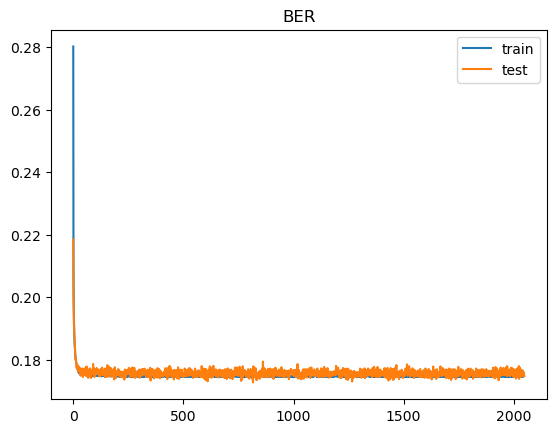

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_ber, label='train')
plt.plot(test_ber, label='test')
plt.legend()
plt.title('BER')
file_jpg = ".jpg"
file_jpg_name = f"{file_name_prefix}_{formatted_datetime}{file_jpg}"
plt.savefig(file_jpg_name)

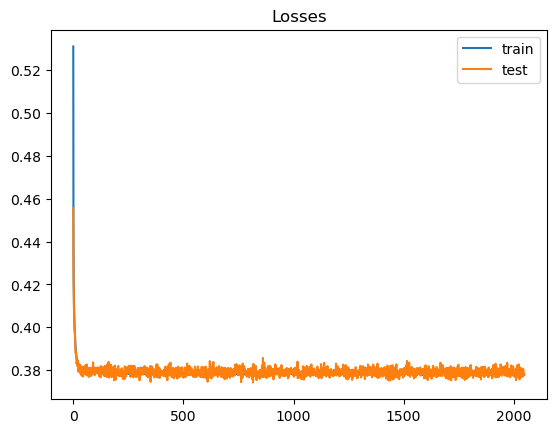

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.title('Losses')
file_jpg = ".png"
file_jpg_name = f"{file_name_prefix}_{formatted_datetime}{file_jpg}"
plt.savefig(file_jpg_name)

In [44]:
#Load model
checkpoint = torch.load('MLP.path')
# checkpoint = torch.load(file_name)
dnn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Simulation

In [45]:
total = sum([param.nelement() for param in dnn.parameters()])

trainable_num = sum(p.numel() for p in dnn.parameters() if p.requires_grad)

print("Number of parameter: %.2f" % (total))

print("Number of trainable_parameter: %.2f" % (trainable_num))

params = list(dnn.parameters())
k = 0
for i in params:
    l = 1
    print("Structure：" + str(list(i.size())))
    for j in i.size():
        l *= j
    print("Parameter number：" + str(l))
    k = k + l
print("Total parameter number：" + str(k))

Number of parameter: 37000.00
Number of trainable_parameter: 37000.00
Structure：[128, 16]
Parameter number：2048
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128, 128]
Parameter number：16384
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128, 128]
Parameter number：16384
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[128]
Parameter number：128
Structure：[8, 128]
Parameter number：1024
Structure：[8]
Parameter number：8
Total parameter number：37000


In [46]:
def fails(list1, list2):
    """returns number of bit errors"""
    return pcf.np.sum(pcf.np.absolute(list1 - list2))

In [48]:
import polar_codes.polar_coding_functions as pcf
EbN0=7
Frame_number=100000
for j in range(EbN0):#EbN0
    fer=0
    ber=0
    sinrdb = j
    channel = BpskAwgnChannel(sinrdb,R)
    rprofile = rateprofile(N,K,sinrdb)
    sum_time = 0
    for i in range(Frame_number):
        code = PACCode(N=N, K=K, construct='rm-polar',dSNR=sinrdb, rprofile=rprofile)
        u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8')

        x_message = code.pac_encode(u_message, conv_gen, mem)

        to_message = channel.modulate(x_message)
        from_message = channel.transmit(to_message)

        if LLR_Model  == 'Hard':
            y_message = channel.demodulate(from_message)
        elif LLR_Model  == 'Dire':
            y_message = from_message
        elif LLR_Model == 'Calc':
            y_message = channel.cal_llr(from_message)
        else:
            raise SystemExit('Please select the correct input')
        y_message_tensor = torch.tensor(y_message, dtype=torch.float32).unsqueeze(0)
        y_message_tensor = y_message_tensor.to(device)
        if Test_Model == 'CNN': 
            y_message_tensor = torch.reshape(y_message_tensor, [-1, 1, 1, N])
        elif Test_Model == 'RNN':
            y_message_tensor = torch.reshape(y_message_tensor, [-1, 1, N])
        
        start_time = time.time()
        out = dnn(y_message_tensor)
        out = (out > 0.5).type(torch.int64).cpu().numpy()[0]        
        end_time = time.time()
        sum_time = sum_time + (end_time-start_time)
        
        ber += fails(u_message, out)

        if not pcf.np.array_equal(u_message, out):
            fer += 1
    print("Eb/N0:",j,"FER",fer/Frame_number,"BER",ber/Frame_number/K)
    print(sum_time/Frame_number)

Eb/N0: 0 FER 0.40181 BER 0.171395
0.00033933868885040284
Eb/N0: 1 FER 0.27371 BER 0.1115775
0.00034025192975997926
Eb/N0: 2 FER 0.16545 BER 0.0633575
0.00033948930025100706
Eb/N0: 3 FER 0.08384 BER 0.03000875
0.0003406120991706848
Eb/N0: 4 FER 0.03547 BER 0.01161
0.00033646308183670046
Eb/N0: 5 FER 0.0128 BER 0.00396
0.0003381465029716492
Eb/N0: 6 FER 0.00359 BER 0.0009425
0.0003393741202354431
